In [1]:
%matplotlib inline
import numpy as np

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import torchvision
from torchvision import transforms, models

from NetworkAPI import NetworkAPI

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Data loaders

In [2]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        #transforms.RandomCrop(28, padding=4),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

image_datasets = {x: torchvision.datasets.CIFAR10(root='./data', 
                                                  transform=data_transforms[x]) for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], 
                                              batch_size=256, 
                                              shuffle=True, 
                                              num_workers=4) for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

## Network architecture template

```
class Network(nn.Module):
    def __init__(self):
        super(NetworkMaxMax, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1), # Output is 32x32x32
            nn.ReLU(inplace=True), # Output is 32x32x32
            nn.BatchNorm2d(32), # Output is 32x32x32
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),# Output is 32x32x32
            nn.ReLU(inplace=True), # Output is 32x32x32
            nn.BatchNorm2d(32), # Output is 32x32x32
#             nn.MaxPool2d(kernel_size=2, stride=2), # Output is 32x16x16
            nn.Dropout2d(0.2) # Output is 32x16x16
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1), # Output is 64x16x16
            nn.ReLU(inplace=True), # Output is 64x16x16
            nn.BatchNorm2d(64), # Output is 64x16x16
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),# Output is 64x16x16
            nn.ReLU(inplace=True), # Output is 64x16x16
            nn.BatchNorm2d(64), # Output is 64x16x16
#             nn.MaxPool2d(kernel_size=2, stride=2), # Output is 64x8x8
            nn.Dropout2d(0.3)
        )
        
        self.flatten = nn.Sequential(
            nn.Linear(64*8*8, 256),
            nn.Linear(256,64)
        )
        self.classifier = nn.Sequential(
            nn.Linear(64,10),
            nn.Softmax(-1)
        )
    
    def forward(self,x):
        x = self.conv1(x) # Change size from 3x32x32 to 32x16x16
        x = self.conv2(x) # Change size from 32x16x16 to 64x16x16
        x = x.view(-1, 64*8*8)
        x = self.flatten(x)
        x = self.classifier(x)
        return x
```

# Pooling tests

20 epochs

2 sekwencje: Conv, ReLU, Batch, Conv, ReLU, Batch, Pool

Wszystkie kombinacje Pooli:

* Max -- Max
* Max -- Avg
* Avg -- Max
* Avg -- Avg

In [3]:
eps = 30

## Max -- Max

In [4]:
class NetworkMaxMax(nn.Module):
    def __init__(self):
        super(NetworkMaxMax, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1), # Output is 32x32x32
            nn.ReLU(inplace=True), # Output is 32x32x32
            nn.BatchNorm2d(32), # Output is 32x32x32
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),# Output is 32x32x32
            nn.ReLU(inplace=True), # Output is 32x32x32
            nn.BatchNorm2d(32), # Output is 32x32x32
            nn.MaxPool2d(kernel_size=2, stride=2), # Output is 32x16x16
            nn.Dropout2d(0.2) # Output is 32x16x16
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1), # Output is 64x16x16
            nn.ReLU(inplace=True), # Output is 64x16x16
            nn.BatchNorm2d(64), # Output is 64x16x16
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),# Output is 64x16x16
            nn.ReLU(inplace=True), # Output is 64x16x16
            nn.BatchNorm2d(64), # Output is 64x64x64
            nn.MaxPool2d(kernel_size=2, stride=2), # Output is 64x8x8
            nn.Dropout2d(0.3)
        )
        
        self.flatten = nn.Sequential(
            nn.Linear(64*8*8, 256),
            nn.Linear(256,64)
        )
        self.classifier = nn.Sequential(
            nn.Linear(64,10),
            nn.Softmax(-1)
        )
    
    def forward(self,x):
        x = self.conv1(x) # Change size from 3x32x32 to 32x16x16
        x = self.conv2(x) # Change size from 32x16x16 to 64x16x16
        x = x.view(-1, 64*8*8)
        x = self.flatten(x)
        x = self.classifier(x)
        return x

====== HYPERPARAMETERS ======
starting epoch= 0
epochs to go= 30
Starting learning rate= 0.1
--------------------------------------------------------------------
| Epoch:   1 | Time:  23.84s | Train loss:  2.13 | Train acc: 34.48|
| Epoch:   1 | Time:  13.20s | Val loss:    2.03 | Val acc:   43.08|
--------------------------------------------------------------------
| Epoch:   2 | Time:  22.90s | Train loss:  2.00 | Train acc: 46.98|
| Epoch:   2 | Time:  13.13s | Val loss:    1.95 | Val acc:   51.56|
--------------------------------------------------------------------
| Epoch:   3 | Time:  22.96s | Train loss:  1.94 | Train acc: 53.00|
| Epoch:   3 | Time:  13.26s | Val loss:    1.89 | Val acc:   57.04|
--------------------------------------------------------------------
| Epoch:   4 | Time:  22.93s | Train loss:  1.89 | Train acc: 57.19|
| Epoch:   4 | Time:  13.22s | Val loss:    1.85 | Val acc:   61.61|
--------------------------------------------------------------------
| Epoch:  

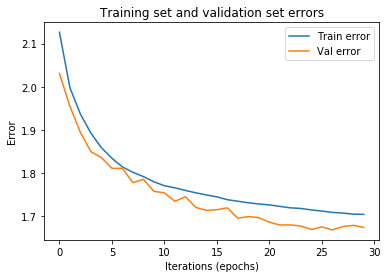

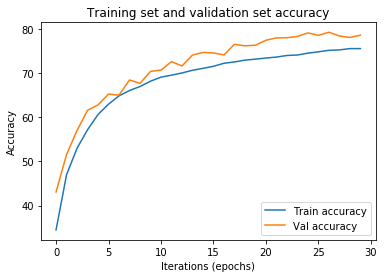

| Class                   | Train  | Test  |
--------------------------------------------
| Accuracy of: airplane   | 72.50% | 72.78%|
| Accuracy of: automobile | 90.78% | 90.80%|
| Accuracy of: bird       | 62.82% | 62.46%|
| Accuracy of: cat        | 61.52% | 61.64%|
| Accuracy of: deer       | 76.38% | 76.68%|
| Accuracy of: dog        | 77.14% | 77.18%|
| Accuracy of: frog       | 84.70% | 84.44%|
| Accuracy of: horse      | 80.44% | 80.44%|
| Accuracy of: ship       | 88.30% | 88.16%|
| Accuracy of: truck      | 92.02% | 92.16%|


In [5]:
np.random.seed = 0

model = NetworkMaxMax().to(device)
brain = NetworkAPI(model, dataloaders, 'arch_MaxMax', optim.SGD(model.parameters(), lr=0.1), lr=0.1)
# brain.load_checkpoint()
errors = brain.train_loop(epochs=eps)
brain.plot_errors()
brain.plot_accuracy()
brain.class_accuracy(class_names)

## Max -- Avg

In [6]:
class NetworkMaxAvg(nn.Module):
    def __init__(self):
        super(NetworkMaxAvg, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1), # Output is 32x32x32
            nn.ReLU(inplace=True), # Output is 32x32x32
            nn.BatchNorm2d(32), # Output is 32x32x32
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),# Output is 32x32x32
            nn.ReLU(inplace=True), # Output is 32x32x32
            nn.BatchNorm2d(32), # Output is 32x32x32
            nn.MaxPool2d(kernel_size=2, stride=2), # Output is 32x16x16
            nn.Dropout2d(0.2) # Output is 32x16x16
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1), # Output is 64x16x16
            nn.ReLU(inplace=True), # Output is 64x16x16
            nn.BatchNorm2d(64), # Output is 64x16x16
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),# Output is 64x16x16
            nn.ReLU(inplace=True), # Output is 64x16x16
            nn.BatchNorm2d(64), # Output is 64x16x16
            nn.AvgPool2d(kernel_size=2, stride=2), # Output is 64x8x8
            nn.Dropout2d(0.3)
        )
        self.flatten = nn.Sequential(
            nn.Linear(64*8*8, 256),
            nn.Linear(256,64)
        )
        self.classifier = nn.Sequential(
            nn.Linear(64,10),
            nn.Softmax(-1)
        )
    
    def forward(self,x):
        x = self.conv1(x) # Change size from 3x32x32 to 32x16x16
        x = self.conv2(x) # Change size from 32x16x16 to 64x16x16
        x = x.view(-1, 64*8*8)
        x = self.flatten(x)
        x = self.classifier(x)
        return x

====== HYPERPARAMETERS ======
starting epoch= 0
epochs to go= 30
Starting learning rate= 0.1
--------------------------------------------------------------------
| Epoch:   1 | Time:  26.52s | Train loss:  2.17 | Train acc: 29.77|
| Epoch:   1 | Time:  13.06s | Val loss:    2.09 | Val acc:   38.42|
--------------------------------------------------------------------
| Epoch:   2 | Time:  23.19s | Train loss:  2.03 | Train acc: 43.58|
| Epoch:   2 | Time:  13.13s | Val loss:    2.00 | Val acc:   45.97|
--------------------------------------------------------------------
| Epoch:   3 | Time:  23.23s | Train loss:  1.97 | Train acc: 49.92|
| Epoch:   3 | Time:  13.17s | Val loss:    1.92 | Val acc:   54.30|
--------------------------------------------------------------------
| Epoch:   4 | Time:  23.15s | Train loss:  1.93 | Train acc: 53.73|
| Epoch:   4 | Time:  13.08s | Val loss:    1.91 | Val acc:   55.33|
--------------------------------------------------------------------
| Epoch:  

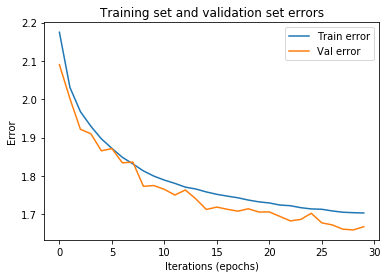

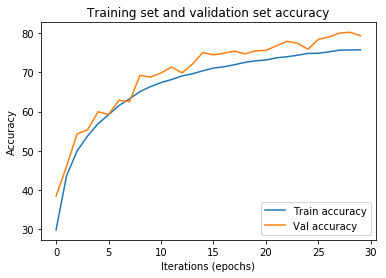

| Class                   | Train  | Test  |
--------------------------------------------
| Accuracy of: airplane   | 80.48% | 81.16%|
| Accuracy of: automobile | 90.34% | 90.44%|
| Accuracy of: bird       | 62.86% | 63.26%|
| Accuracy of: cat        | 74.66% | 74.84%|
| Accuracy of: deer       | 75.44% | 75.02%|
| Accuracy of: dog        | 65.64% | 65.54%|
| Accuracy of: frog       | 85.38% | 85.44%|
| Accuracy of: horse      | 81.84% | 81.18%|
| Accuracy of: ship       | 86.88% | 86.58%|
| Accuracy of: truck      | 90.44% | 90.56%|


In [7]:
np.random.seed = 0

model = NetworkMaxAvg().to(device)
brain = NetworkAPI(model, dataloaders, 'arch_MaxAvg', optim.SGD(model.parameters(), lr=0.1), lr=0.1)
#brain.load_checkpoint()
errors = brain.train_loop(epochs=eps)
brain.plot_errors()
brain.plot_accuracy()
brain.class_accuracy(class_names)

## Max -- No

In [8]:
class NetworkMaxNo(nn.Module):
    def __init__(self):
        super(NetworkMaxNo, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1), # Output is 32x32x32
            nn.ReLU(inplace=True), # Output is 32x32x32
            nn.BatchNorm2d(32), # Output is 32x32x32
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),# Output is 32x32x32
            nn.ReLU(inplace=True), # Output is 32x32x32
            nn.BatchNorm2d(32), # Output is 32x32x32
            nn.MaxPool2d(kernel_size=2, stride=2), # Output is 32x16x16
            nn.Dropout2d(0.2) # Output is 32x16x16
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1), # Output is 64x16x16
            nn.ReLU(inplace=True), # Output is 64x16x16
            nn.BatchNorm2d(64), # Output is 64x16x16
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),# Output is 64x16x16
            nn.ReLU(inplace=True), # Output is 64x16x16
            nn.BatchNorm2d(64), # Output is 64x16x16
            nn.Dropout2d(0.3)
        )
        
        self.flatten = nn.Sequential(
            nn.Linear(64*16*16, 256),
            nn.Linear(256,64)
        )
        self.classifier = nn.Sequential(
            nn.Linear(64,10),
            nn.Softmax(-1)
        )
    
    def forward(self,x):
        x = self.conv1(x) # Change size from 3x32x32 to 32x16x16
        x = self.conv2(x) # Change size from 32x16x16 to 64x16x16
        x = x.view(-1, 64*16*16)
        x = self.flatten(x)
        x = self.classifier(x)
        return x

====== HYPERPARAMETERS ======
starting epoch= 0
epochs to go= 30
Starting learning rate= 0.1
--------------------------------------------------------------------
| Epoch:   1 | Time:  23.75s | Train loss:  2.11 | Train acc: 36.42|
| Epoch:   1 | Time:  13.35s | Val loss:    2.02 | Val acc:   44.03|
--------------------------------------------------------------------
| Epoch:   2 | Time:  23.80s | Train loss:  1.98 | Train acc: 48.91|
| Epoch:   2 | Time:  13.20s | Val loss:    1.96 | Val acc:   50.20|
--------------------------------------------------------------------
| Epoch:   3 | Time:  23.73s | Train loss:  1.91 | Train acc: 55.37|
| Epoch:   3 | Time:  13.38s | Val loss:    1.88 | Val acc:   57.74|
--------------------------------------------------------------------
| Epoch:   4 | Time:  23.91s | Train loss:  1.87 | Train acc: 59.01|
| Epoch:   4 | Time:  13.20s | Val loss:    1.93 | Val acc:   52.83|
--------------------------------------------------------------------
| Epoch:  

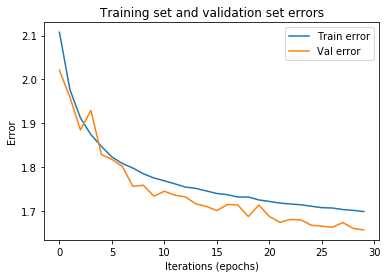

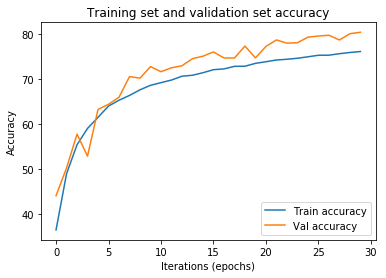

| Class                   | Train  | Test  |
--------------------------------------------
| Accuracy of: airplane   | 78.16% | 78.04%|
| Accuracy of: automobile | 90.96% | 90.60%|
| Accuracy of: bird       | 61.06% | 61.04%|
| Accuracy of: cat        | 67.28% | 67.18%|
| Accuracy of: deer       | 77.50% | 77.62%|
| Accuracy of: dog        | 74.68% | 74.88%|
| Accuracy of: frog       | 88.50% | 88.70%|
| Accuracy of: horse      | 84.82% | 84.98%|
| Accuracy of: ship       | 92.42% | 92.30%|
| Accuracy of: truck      | 88.60% | 88.80%|


In [9]:
np.random.seed = 0

model = NetworkMaxNo().to(device)
brain = NetworkAPI(model, dataloaders, 'arch_MaxNo', optim.SGD(model.parameters(), lr=0.1), lr=0.1)
# brain.load_checkpoint()
errors = brain.train_loop(epochs=eps)
brain.plot_errors()
brain.plot_accuracy()
brain.class_accuracy(class_names)

## Max -- Conv

In [10]:
class NetworkMaxConv(nn.Module):
    def __init__(self):
        super(NetworkMaxConv, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1), # Output is 32x32x32
            nn.ReLU(inplace=True), # Output is 32x32x32
            nn.BatchNorm2d(32), # Output is 32x32x32
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),# Output is 32x32x32
            nn.ReLU(inplace=True), # Output is 32x32x32
            nn.BatchNorm2d(32), # Output is 32x32x32
            nn.AvgPool2d(kernel_size=2, stride=2), # Output is 32x16x16
            nn.Dropout2d(0.2) # Output is 32x16x16
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1), # Output is 64x16x16
            nn.ReLU(inplace=True), # Output is 64x16x16
            nn.BatchNorm2d(64), # Output is 64x16x16
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),# Output is 64x16x16
            nn.ReLU(inplace=True), # Output is 64x16x16
            nn.BatchNorm2d(64), # Output is 64x16x16
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=4, stride=2, padding=1), # Output is 64x8x8
            nn.Dropout2d(0.3)
        )
        self.flatten = nn.Sequential(
            nn.Linear(64*8*8, 256),
            nn.Linear(256,64)
        )
        self.classifier = nn.Sequential(
            nn.Linear(64,10),
            nn.Softmax(-1)
        )
    
    def forward(self,x):
        x = self.conv1(x) # Change size from 3x32x32 to 32x16x16
        x = self.conv2(x) # Change size from 32x16x16 to 64x16x16
        x = x.view(-1, 64*8*8)
        x = self.flatten(x)
        x = self.classifier(x)
        return x

====== HYPERPARAMETERS ======
starting epoch= 0
epochs to go= 30
Starting learning rate= 0.1
--------------------------------------------------------------------
| Epoch:   1 | Time:  25.28s | Train loss:  2.19 | Train acc: 27.16|
| Epoch:   1 | Time:  13.47s | Val loss:    2.11 | Val acc:   34.84|
--------------------------------------------------------------------
| Epoch:   2 | Time:  25.17s | Train loss:  2.04 | Train acc: 42.09|
| Epoch:   2 | Time:  13.24s | Val loss:    2.10 | Val acc:   34.74|
--------------------------------------------------------------------
| Epoch:   3 | Time:  25.15s | Train loss:  1.98 | Train acc: 48.65|
| Epoch:   3 | Time:  13.61s | Val loss:    1.95 | Val acc:   50.94|
--------------------------------------------------------------------
| Epoch:   4 | Time:  25.16s | Train loss:  1.93 | Train acc: 53.22|
| Epoch:   4 | Time:  13.44s | Val loss:    1.93 | Val acc:   52.53|
--------------------------------------------------------------------
| Epoch:  

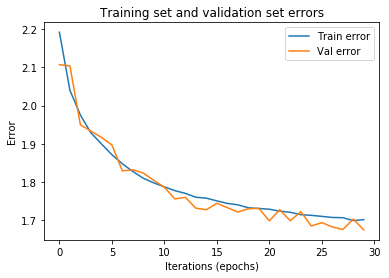

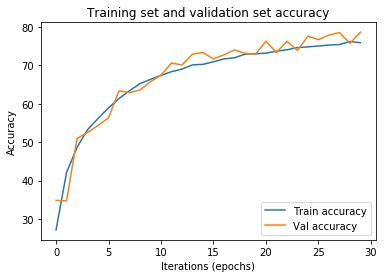

| Class                   | Train  | Test  |
--------------------------------------------
| Accuracy of: airplane   | 80.88% | 80.74%|
| Accuracy of: automobile | 90.82% | 90.36%|
| Accuracy of: bird       | 66.50% | 66.14%|
| Accuracy of: cat        | 62.84% | 62.34%|
| Accuracy of: deer       | 79.52% | 79.72%|
| Accuracy of: dog        | 69.36% | 69.18%|
| Accuracy of: frog       | 79.92% | 79.72%|
| Accuracy of: horse      | 83.98% | 83.84%|
| Accuracy of: ship       | 84.26% | 84.08%|
| Accuracy of: truck      | 90.10% | 89.90%|


In [11]:
np.random.seed = 0

model = NetworkMaxConv().to(device)
brain = NetworkAPI(model, dataloaders, 'arch_MaxConv', optim.SGD(model.parameters(), lr=0.1), lr=0.1)
#brain.load_checkpoint()
errors = brain.train_loop(epochs=eps)
brain.plot_errors()
brain.plot_accuracy()
brain.class_accuracy(class_names)

## Avg -- Max

In [12]:
class NetworkAvgMax(nn.Module):
    def __init__(self):
        super(NetworkAvgMax, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1), # Output is 32x32x32
            nn.ReLU(inplace=True), # Output is 32x32x32
            nn.BatchNorm2d(32), # Output is 32x32x32
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),# Output is 32x32x32
            nn.ReLU(inplace=True), # Output is 32x32x32
            nn.BatchNorm2d(32), # Output is 32x32x32
            nn.AvgPool2d(kernel_size=2, stride=2), # Output is 32x16x16
            nn.Dropout2d(0.2) # Output is 32x16x16
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1), # Output is 64x16x16
            nn.ReLU(inplace=True), # Output is 64x16x16
            nn.BatchNorm2d(64), # Output is 64x16x16
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),# Output is 64x16x16
            nn.ReLU(inplace=True), # Output is 64x16x16
            nn.BatchNorm2d(64), # Output is 64x16x16
            nn.MaxPool2d(kernel_size=2, stride=2), # Output is 64x8x8
            nn.Dropout2d(0.3)
        )
        self.flatten = nn.Sequential(
            nn.Linear(64*8*8, 256),
            nn.Linear(256,64)
        )
        self.classifier = nn.Sequential(
            nn.Linear(64,10),
            nn.Softmax(-1)
        )
    
    def forward(self,x):
        x = self.conv1(x) # Change size from 3x32x32 to 32x16x16
        x = self.conv2(x) # Change size from 32x16x16 to 64x16x16
        x = x.view(-1, 64*8*8)
        x = self.flatten(x)
        x = self.classifier(x)
        return x

====== HYPERPARAMETERS ======
starting epoch= 0
epochs to go= 30
Starting learning rate= 0.1
--------------------------------------------------------------------
| Epoch:   1 | Time:  23.44s | Train loss:  2.14 | Train acc: 32.23|
| Epoch:   1 | Time:  13.10s | Val loss:    2.04 | Val acc:   42.06|
--------------------------------------------------------------------
| Epoch:   2 | Time:  23.49s | Train loss:  2.01 | Train acc: 45.44|
| Epoch:   2 | Time:  13.22s | Val loss:    2.00 | Val acc:   45.65|
--------------------------------------------------------------------
| Epoch:   3 | Time:  23.65s | Train loss:  1.95 | Train acc: 51.48|
| Epoch:   3 | Time:  13.16s | Val loss:    1.94 | Val acc:   52.42|
--------------------------------------------------------------------
| Epoch:   4 | Time:  23.49s | Train loss:  1.90 | Train acc: 56.62|
| Epoch:   4 | Time:  13.45s | Val loss:    1.87 | Val acc:   59.10|
--------------------------------------------------------------------
| Epoch:  

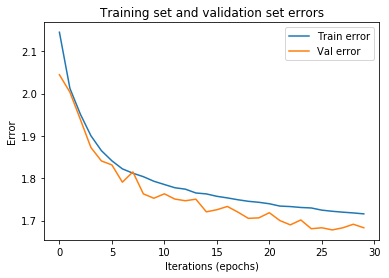

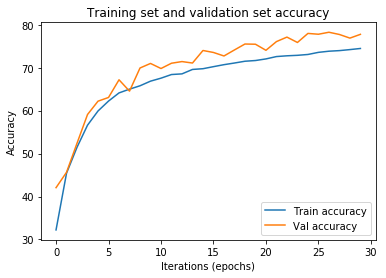

| Class                   | Train  | Test  |
--------------------------------------------
| Accuracy of: airplane   | 74.70% | 74.98%|
| Accuracy of: automobile | 90.76% | 90.72%|
| Accuracy of: bird       | 69.98% | 70.08%|
| Accuracy of: cat        | 66.80% | 66.88%|
| Accuracy of: deer       | 65.42% | 64.66%|
| Accuracy of: dog        | 71.22% | 71.20%|
| Accuracy of: frog       | 85.00% | 85.04%|
| Accuracy of: horse      | 76.62% | 76.76%|
| Accuracy of: ship       | 89.98% | 89.62%|
| Accuracy of: truck      | 87.88% | 87.76%|


In [13]:
np.random.seed = 0

model = NetworkAvgMax().to(device)
brain = NetworkAPI(model, dataloaders, 'arch_AvgMax', optim.SGD(model.parameters(), lr=0.1), lr=0.1)
#brain.load_checkpoint()
errors = brain.train_loop(epochs=eps)
brain.plot_errors()
brain.plot_accuracy()
brain.class_accuracy(class_names)

## Avg -- Avg

In [14]:
class NetworkAvgAvg(nn.Module):
    def __init__(self):
        super(NetworkAvgAvg, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1), # Output is 32x32x32
            nn.ReLU(inplace=True), # Output is 32x32x32
            nn.BatchNorm2d(32), # Output is 32x32x32
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),# Output is 32x32x32
            nn.ReLU(inplace=True), # Output is 32x32x32
            nn.BatchNorm2d(32), # Output is 32x32x32
            nn.AvgPool2d(kernel_size=2, stride=2), # Output is 32x16x16
            nn.Dropout2d(0.2) # Output is 32x16x16
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1), # Output is 64x16x16
            nn.ReLU(inplace=True), # Output is 64x16x16
            nn.BatchNorm2d(64), # Output is 64x16x16
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),# Output is 64x16x16
            nn.ReLU(inplace=True), # Output is 64x16x16
            nn.BatchNorm2d(64), # Output is 64x16x16
            nn.AvgPool2d(kernel_size=2, stride=2), # Output is 64x8x8
            nn.Dropout2d(0.3)
        )
        self.flatten = nn.Sequential(
            nn.Linear(64*8*8, 256),
            nn.Linear(256,64)
        )
        self.classifier = nn.Sequential(
            nn.Linear(64,10),
            nn.Softmax(-1)
        )
    
    def forward(self,x):
        x = self.conv1(x) # Change size from 3x32x32 to 32x16x16
        x = self.conv2(x) # Change size from 32x16x16 to 64x16x16
        x = x.view(-1, 64*8*8)
        x = self.flatten(x)
        x = self.classifier(x)
        return x

====== HYPERPARAMETERS ======
starting epoch= 0
epochs to go= 30
Starting learning rate= 0.1
--------------------------------------------------------------------
| Epoch:   1 | Time:  23.77s | Train loss:  2.19 | Train acc: 26.72|
| Epoch:   1 | Time:  13.39s | Val loss:    2.12 | Val acc:   35.06|
--------------------------------------------------------------------
| Epoch:   2 | Time:  23.73s | Train loss:  2.06 | Train acc: 40.41|
| Epoch:   2 | Time:  13.24s | Val loss:    2.03 | Val acc:   43.29|
--------------------------------------------------------------------
| Epoch:   3 | Time:  23.79s | Train loss:  2.00 | Train acc: 46.91|
| Epoch:   3 | Time:  13.17s | Val loss:    1.96 | Val acc:   50.12|
--------------------------------------------------------------------
| Epoch:   4 | Time:  23.68s | Train loss:  1.95 | Train acc: 51.71|
| Epoch:   4 | Time:  13.21s | Val loss:    1.94 | Val acc:   53.00|
--------------------------------------------------------------------
| Epoch:  

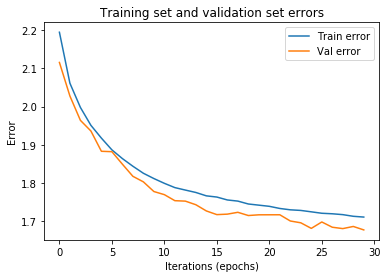

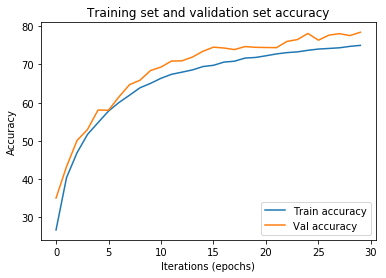

| Class                   | Train  | Test  |
--------------------------------------------
| Accuracy of: airplane   | 78.42% | 78.18%|
| Accuracy of: automobile | 90.50% | 90.76%|
| Accuracy of: bird       | 71.22% | 71.32%|
| Accuracy of: cat        | 55.86% | 55.90%|
| Accuracy of: deer       | 73.64% | 74.06%|
| Accuracy of: dog        | 66.68% | 66.80%|
| Accuracy of: frog       | 87.10% | 87.48%|
| Accuracy of: horse      | 83.44% | 83.64%|
| Accuracy of: ship       | 86.60% | 86.36%|
| Accuracy of: truck      | 89.82% | 89.86%|


In [15]:
np.random.seed = 0

model = NetworkAvgAvg().to(device)
brain = NetworkAPI(model, dataloaders, 'arch_AvgAvg', optim.SGD(model.parameters(), lr=0.1), lr=0.1)
#brain.load_checkpoint()
errors = brain.train_loop(epochs=eps)
brain.plot_errors()
brain.plot_accuracy()
brain.class_accuracy(class_names)

## Avg -- No

In [16]:
class NetworkAvgNo(nn.Module):
    def __init__(self):
        super(NetworkAvgNo, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1), # Output is 32x32x32
            nn.ReLU(inplace=True), # Output is 32x32x32
            nn.BatchNorm2d(32), # Output is 32x32x32
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),# Output is 32x32x32
            nn.ReLU(inplace=True), # Output is 32x32x32
            nn.BatchNorm2d(32), # Output is 32x32x32
            nn.AvgPool2d(kernel_size=2, stride=2), # Output is 32x16x16
            nn.Dropout2d(0.2) # Output is 32x16x16
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1), # Output is 64x16x16
            nn.ReLU(inplace=True), # Output is 64x16x16
            nn.BatchNorm2d(64), # Output is 64x16x16
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),# Output is 64x16x16
            nn.ReLU(inplace=True), # Output is 64x16x16
            nn.BatchNorm2d(64), # Output is 64x16x16
            nn.Dropout2d(0.3)
        )
        
        self.flatten = nn.Sequential(
            nn.Linear(64*16*16, 256),
            nn.Linear(256,64)
        )
        self.classifier = nn.Sequential(
            nn.Linear(64,10),
            nn.Softmax(-1)
        )
    
    def forward(self,x):
        x = self.conv1(x) # Change size from 3x32x32 to 32x16x16
        x = self.conv2(x) # Change size from 32x16x16 to 64x16x16
        x = x.view(-1, 64*16*16)
        x = self.flatten(x)
        x = self.classifier(x)
        return x

====== HYPERPARAMETERS ======
starting epoch= 0
epochs to go= 30
Starting learning rate= 0.1
--------------------------------------------------------------------
| Epoch:   1 | Time:  24.28s | Train loss:  2.11 | Train acc: 35.93|
| Epoch:   1 | Time:  13.46s | Val loss:    2.03 | Val acc:   43.24|
--------------------------------------------------------------------
| Epoch:   2 | Time:  24.30s | Train loss:  1.99 | Train acc: 47.34|
| Epoch:   2 | Time:  13.18s | Val loss:    1.94 | Val acc:   52.48|
--------------------------------------------------------------------
| Epoch:   3 | Time:  24.41s | Train loss:  1.95 | Train acc: 51.74|
| Epoch:   3 | Time:  13.41s | Val loss:    2.05 | Val acc:   41.05|
--------------------------------------------------------------------
| Epoch:   4 | Time:  24.31s | Train loss:  1.91 | Train acc: 55.50|
| Epoch:   4 | Time:  13.24s | Val loss:    1.90 | Val acc:   56.70|
--------------------------------------------------------------------
| Epoch:  

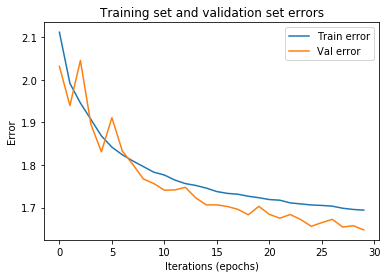

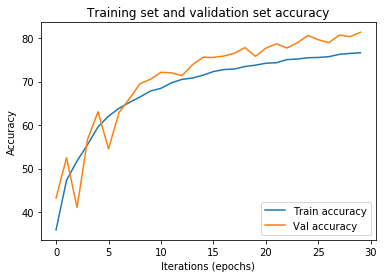

| Class                   | Train  | Test  |
--------------------------------------------
| Accuracy of: airplane   | 86.90% | 87.26%|
| Accuracy of: automobile | 90.92% | 91.10%|
| Accuracy of: bird       | 65.32% | 64.98%|
| Accuracy of: cat        | 66.22% | 66.06%|
| Accuracy of: deer       | 73.26% | 73.86%|
| Accuracy of: dog        | 74.48% | 74.80%|
| Accuracy of: frog       | 88.78% | 88.76%|
| Accuracy of: horse      | 85.88% | 85.14%|
| Accuracy of: ship       | 88.54% | 88.90%|
| Accuracy of: truck      | 92.12% | 92.26%|


In [17]:
np.random.seed = 0

model = NetworkAvgNo().to(device)
brain = NetworkAPI(model, dataloaders, 'arch_AvgNo', optim.SGD(model.parameters(), lr=0.1), lr=0.1)
# brain.load_checkpoint()
errors = brain.train_loop(epochs=eps)
brain.plot_errors()
brain.plot_accuracy()
brain.class_accuracy(class_names)

## Avg -- Conv

In [18]:
class NetworkAvgConv(nn.Module):
    def __init__(self):
        super(NetworkAvgConv, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1), # Output is 32x32x32
            nn.ReLU(inplace=True), # Output is 32x32x32
            nn.BatchNorm2d(32), # Output is 32x32x32
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),# Output is 32x32x32
            nn.ReLU(inplace=True), # Output is 32x32x32
            nn.BatchNorm2d(32), # Output is 32x32x32
            nn.AvgPool2d(kernel_size=2, stride=2), # Output is 32x16x16
            nn.Dropout2d(0.2) # Output is 32x16x16
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1), # Output is 64x16x16
            nn.ReLU(inplace=True), # Output is 64x16x16
            nn.BatchNorm2d(64), # Output is 64x16x16
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),# Output is 64x16x16
            nn.ReLU(inplace=True), # Output is 64x16x16
            nn.BatchNorm2d(64), # Output is 64x16x16
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=4, stride=2, padding=1), # Output is 64x8x8
            nn.Dropout2d(0.3)
        )
        self.flatten = nn.Sequential(
            nn.Linear(64*8*8, 256),
            nn.Linear(256,64)
        )
        self.classifier = nn.Sequential(
            nn.Linear(64,10),
            nn.Softmax(-1)
        )
    
    def forward(self,x):
        x = self.conv1(x) # Change size from 3x32x32 to 32x16x16
        x = self.conv2(x) # Change size from 32x16x16 to 64x16x16
        x = x.view(-1, 64*8*8)
        x = self.flatten(x)
        x = self.classifier(x)
        return x

====== HYPERPARAMETERS ======
starting epoch= 0
epochs to go= 30
Starting learning rate= 0.1
--------------------------------------------------------------------
| Epoch:   1 | Time:  25.22s | Train loss:  2.20 | Train acc: 26.34|
| Epoch:   1 | Time:  13.17s | Val loss:    2.11 | Val acc:   35.13|
--------------------------------------------------------------------
| Epoch:   2 | Time:  25.20s | Train loss:  2.04 | Train acc: 42.26|
| Epoch:   2 | Time:  13.39s | Val loss:    2.02 | Val acc:   43.56|
--------------------------------------------------------------------
| Epoch:   3 | Time:  25.20s | Train loss:  1.98 | Train acc: 48.53|
| Epoch:   3 | Time:  13.12s | Val loss:    1.96 | Val acc:   49.35|
--------------------------------------------------------------------
| Epoch:   4 | Time:  25.31s | Train loss:  1.93 | Train acc: 52.99|
| Epoch:   4 | Time:  13.68s | Val loss:    1.90 | Val acc:   55.83|
--------------------------------------------------------------------
| Epoch:  

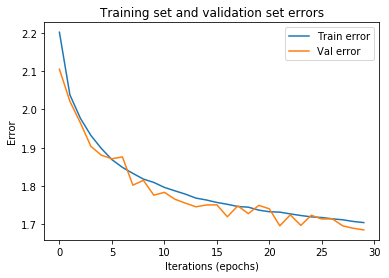

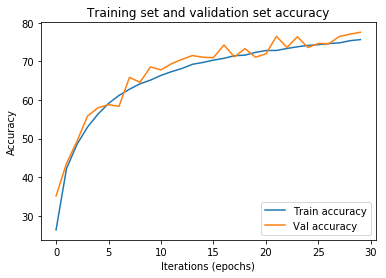

| Class                   | Train  | Test  |
--------------------------------------------
| Accuracy of: airplane   | 78.36% | 78.72%|
| Accuracy of: automobile | 86.90% | 86.92%|
| Accuracy of: bird       | 66.48% | 66.86%|
| Accuracy of: cat        | 61.84% | 62.16%|
| Accuracy of: deer       | 73.32% | 73.66%|
| Accuracy of: dog        | 59.86% | 60.04%|
| Accuracy of: frog       | 88.98% | 88.94%|
| Accuracy of: horse      | 77.30% | 77.64%|
| Accuracy of: ship       | 90.76% | 91.02%|
| Accuracy of: truck      | 89.52% | 89.44%|


In [19]:
np.random.seed = 0

model = NetworkAvgConv().to(device)
brain = NetworkAPI(model, dataloaders, 'arch_AvgConv', optim.SGD(model.parameters(), lr=0.1), lr=0.1)
#brain.load_checkpoint()
errors = brain.train_loop(epochs=eps)
brain.plot_errors()
brain.plot_accuracy()
brain.class_accuracy(class_names)

## No -- Max

In [20]:
class NetworkNoMax(nn.Module):
    def __init__(self):
        super(NetworkNoMax, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1), # Output is 32x32x32
            nn.ReLU(inplace=True), # Output is 32x32x32
            nn.BatchNorm2d(32), # Output is 32x32x32
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),# Output is 32x32x32
            nn.ReLU(inplace=True), # Output is 32x32x32
            nn.BatchNorm2d(32), # Output is 32x32x32
            nn.Dropout2d(0.2) # Output is 32x32x32
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1), # Output is 64x32x32
            nn.ReLU(inplace=True), # Output is 64x32x32
            nn.BatchNorm2d(64), # Output is 64x32x32
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),# Output is 64x32x32
            nn.ReLU(inplace=True), # Output is 64x32x32
            nn.BatchNorm2d(64), # Output is 64x32x32
            nn.MaxPool2d(kernel_size=2, stride=2), # Output is 64x16x16
            nn.Dropout2d(0.3)
        )
        
        self.flatten = nn.Sequential(
            nn.Linear(64*16*16, 256),
            nn.Linear(256,64)
        )
        self.classifier = nn.Sequential(
            nn.Linear(64,10),
            nn.Softmax(-1)
        )
    
    def forward(self,x):
        x = self.conv1(x) # Change size from 3x32x32 to 32x16x16
        x = self.conv2(x) # Change size from 32x16x16 to 64x16x16
        x = x.view(-1, 64*16*16)
        x = self.flatten(x)
        x = self.classifier(x)
        return x

====== HYPERPARAMETERS ======
starting epoch= 0
epochs to go= 30
Starting learning rate= 0.1
--------------------------------------------------------------------
| Epoch:   1 | Time:  40.92s | Train loss:  2.10 | Train acc: 36.89|
| Epoch:   1 | Time:  17.93s | Val loss:    2.04 | Val acc:   42.31|
--------------------------------------------------------------------
| Epoch:   2 | Time:  40.97s | Train loss:  1.97 | Train acc: 49.68|
| Epoch:   2 | Time:  17.91s | Val loss:    1.94 | Val acc:   52.08|
--------------------------------------------------------------------
| Epoch:   3 | Time:  40.83s | Train loss:  1.91 | Train acc: 55.15|
| Epoch:   3 | Time:  17.98s | Val loss:    1.90 | Val acc:   56.76|
--------------------------------------------------------------------
| Epoch:   4 | Time:  41.16s | Train loss:  1.88 | Train acc: 58.64|
| Epoch:   4 | Time:  17.87s | Val loss:    1.91 | Val acc:   55.01|
--------------------------------------------------------------------
| Epoch:  

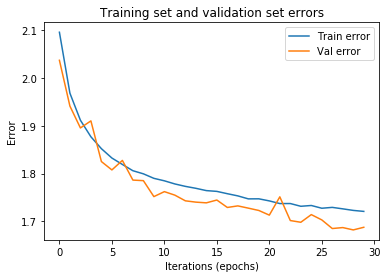

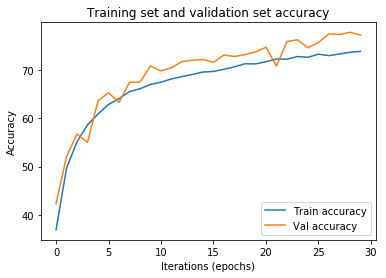

| Class                   | Train  | Test  |
--------------------------------------------
| Accuracy of: airplane   | 70.34% | 70.28%|
| Accuracy of: automobile | 91.74% | 91.46%|
| Accuracy of: bird       | 66.12% | 66.20%|
| Accuracy of: cat        | 63.42% | 62.94%|
| Accuracy of: deer       | 76.08% | 75.88%|
| Accuracy of: dog        | 71.18% | 71.16%|
| Accuracy of: frog       | 83.68% | 83.90%|
| Accuracy of: horse      | 75.16% | 74.82%|
| Accuracy of: ship       | 90.38% | 90.44%|
| Accuracy of: truck      | 85.46% | 85.20%|


In [21]:
np.random.seed = 0

model = NetworkNoMax().to(device)
brain = NetworkAPI(model, dataloaders, 'arch_NoMax', optim.SGD(model.parameters(), lr=0.1), lr=0.1)
# brain.load_checkpoint()
errors = brain.train_loop(epochs=eps)
brain.plot_errors()
brain.plot_accuracy()
brain.class_accuracy(class_names)

## No -- Avg

In [22]:
class NetworkNoAvg(nn.Module):
    def __init__(self):
        super(NetworkNoAvg, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1), # Output is 32x32x32
            nn.ReLU(inplace=True), # Output is 32x32x32
            nn.BatchNorm2d(32), # Output is 32x32x32
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),# Output is 32x32x32
            nn.ReLU(inplace=True), # Output is 32x32x32
            nn.BatchNorm2d(32), # Output is 32x32x32
            nn.Dropout2d(0.2) # Output is 32x32x32
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1), # Output is 64x32x32
            nn.ReLU(inplace=True), # Output is 64x32x32
            nn.BatchNorm2d(64), # Output is 64x32x32
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),# Output is 64x32x32
            nn.ReLU(inplace=True), # Output is 64x32x32
            nn.BatchNorm2d(64), # Output is 64x32x32
            nn.AvgPool2d(kernel_size=2, stride=2), # Output is 64x16x16
            nn.Dropout2d(0.3)
        )
        
        self.flatten = nn.Sequential(
            nn.Linear(64*16*16, 256),
            nn.Linear(256,64)
        )
        self.classifier = nn.Sequential(
            nn.Linear(64,10),
            nn.Softmax(-1)
        )
    
    def forward(self,x):
        x = self.conv1(x) # Change size from 3x32x32 to 32x16x16
        x = self.conv2(x) # Change size from 32x16x16 to 64x16x16
        x = x.view(-1, 64*16*16)
        x = self.flatten(x)
        x = self.classifier(x)
        return x

====== HYPERPARAMETERS ======
starting epoch= 0
epochs to go= 30
Starting learning rate= 0.1
--------------------------------------------------------------------
| Epoch:   1 | Time:  42.04s | Train loss:  2.14 | Train acc: 33.07|
| Epoch:   1 | Time:  18.55s | Val loss:    2.05 | Val acc:   41.67|
--------------------------------------------------------------------
| Epoch:   2 | Time:  42.13s | Train loss:  2.01 | Train acc: 45.30|
| Epoch:   2 | Time:  18.19s | Val loss:    1.98 | Val acc:   48.54|
--------------------------------------------------------------------
| Epoch:   3 | Time:  42.04s | Train loss:  1.96 | Train acc: 50.72|
| Epoch:   3 | Time:  17.79s | Val loss:    1.92 | Val acc:   54.20|
--------------------------------------------------------------------
| Epoch:   4 | Time:  42.28s | Train loss:  1.91 | Train acc: 55.80|
| Epoch:   4 | Time:  18.28s | Val loss:    1.93 | Val acc:   52.63|
--------------------------------------------------------------------
| Epoch:  

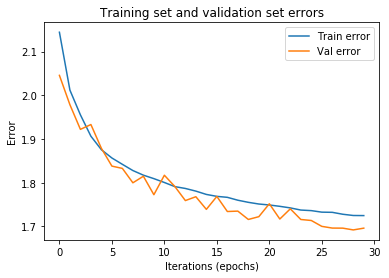

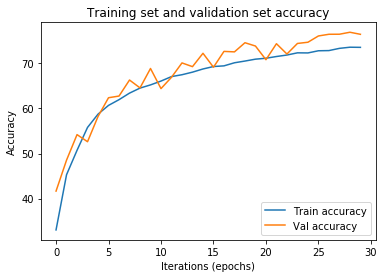

| Class                   | Train  | Test  |
--------------------------------------------
| Accuracy of: airplane   | 79.64% | 79.92%|
| Accuracy of: automobile | 89.52% | 89.22%|
| Accuracy of: bird       | 53.42% | 53.12%|
| Accuracy of: cat        | 62.12% | 61.94%|
| Accuracy of: deer       | 76.54% | 76.60%|
| Accuracy of: dog        | 70.58% | 70.32%|
| Accuracy of: frog       | 83.80% | 83.60%|
| Accuracy of: horse      | 81.66% | 81.46%|
| Accuracy of: ship       | 79.86% | 80.36%|
| Accuracy of: truck      | 88.12% | 87.90%|


In [23]:
np.random.seed = 0

model = NetworkNoAvg().to(device)
brain = NetworkAPI(model, dataloaders, 'arch_NoAvg', optim.SGD(model.parameters(), lr=0.1), lr=0.1)
# brain.load_checkpoint()
errors = brain.train_loop(epochs=eps)
brain.plot_errors()
brain.plot_accuracy()
brain.class_accuracy(class_names)

## No -- No

In [ ]:
class NetworkNoNo(nn.Module):
    def __init__(self):
        super(NetworkNoNo, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1), # Output is 32x32x32
            nn.ReLU(inplace=True), # Output is 32x32x32
            nn.BatchNorm2d(32), # Output is 32x32x32
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),# Output is 32x32x32
            nn.ReLU(inplace=True), # Output is 32x32x32
            nn.BatchNorm2d(32), # Output is 32x32x32
            nn.Dropout2d(0.2) # Output is 32x32x32
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1), # Output is 64x32x32
            nn.ReLU(inplace=True), # Output is 64x32x32
            nn.BatchNorm2d(64), # Output is 64x32x32
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),# Output is 64x32x32
            nn.ReLU(inplace=True), # Output is 64x32x32
            nn.BatchNorm2d(64), # Output is 64x32x32
            nn.Dropout2d(0.3)
        )
        
        self.flatten = nn.Sequential(
            nn.Linear(64*32*32, 256),
            nn.Linear(256,64)
        )
        self.classifier = nn.Sequential(
            nn.Linear(64,10),
            nn.Softmax(-1)
        )
    
    def forward(self,x):
        x = self.conv1(x) # Change size from 3x32x32 to 32x16x16
        x = self.conv2(x) # Change size from 32x16x16 to 64x16x16
        x = x.view(-1, 64*32*32)
        x = self.flatten(x)
        x = self.classifier(x)
        return x

In [ ]:
np.random.seed = 0

model = NetworkNoNo().to(device)
brain = NetworkAPI(model, dataloaders, 'arch_NoNo', optim.SGD(model.parameters(), lr=0.1), lr=0.1)
# brain.load_checkpoint()
errors = brain.train_loop(epochs=eps)
brain.plot_errors()
brain.plot_accuracy()
brain.class_accuracy(class_names)

====== HYPERPARAMETERS ======
starting epoch= 0
epochs to go= 30
Starting learning rate= 0.1
--------------------------------------------------------------------
| Epoch:   1 | Time:  44.48s | Train loss:  2.06 | Train acc: 40.94|
| Epoch:   1 | Time:  19.11s | Val loss:    1.96 | Val acc:   49.93|
--------------------------------------------------------------------
| Epoch:   2 | Time:  44.39s | Train loss:  1.95 | Train acc: 51.44|
| Epoch:   2 | Time:  19.22s | Val loss:    1.95 | Val acc:   51.12|
--------------------------------------------------------------------
| Epoch:   3 | Time:  44.41s | Train loss:  1.90 | Train acc: 55.86|
| Epoch:   3 | Time:  19.11s | Val loss:    1.87 | Val acc:   58.86|
--------------------------------------------------------------------
| Epoch:   4 | Time:  44.42s | Train loss:  1.87 | Train acc: 58.77|
| Epoch:   4 | Time:  18.94s | Val loss:    1.86 | Val acc:   60.48|
--------------------------------------------------------------------
| Epoch:  

## No -- Conv

In [ ]:
class NetworkNoConv(nn.Module):
    def __init__(self):
        super(NetworkNoConv, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1), # Output is 32x32x32
            nn.ReLU(inplace=True), # Output is 32x32x32
            nn.BatchNorm2d(32), # Output is 32x32x32
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),# Output is 32x32x32
            nn.ReLU(inplace=True), # Output is 32x32x32
            nn.BatchNorm2d(32), # Output is 32x32x32
            nn.Dropout2d(0.2) # Output is 32x32x32
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1), # Output is 64x32x32
            nn.ReLU(inplace=True), # Output is 64x32x32
            nn.BatchNorm2d(64), # Output is 64x32x32
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),# Output is 64x32x32
            nn.ReLU(inplace=True), # Output is 64x32x32
            nn.BatchNorm2d(64), # Output is 64x32x32
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=4, stride=2, padding=1), # Output is 64x16x16
            nn.Dropout2d(0.3)
        )
        
        self.flatten = nn.Sequential(
            nn.Linear(64*16*16, 256),
            nn.Linear(256,64)
        )
        self.classifier = nn.Sequential(
            nn.Linear(64,10),
            nn.Softmax(-1)
        )
    
    def forward(self,x):
        x = self.conv1(x) # Change size from 3x32x32 to 32x16x16
        x = self.conv2(x) # Change size from 32x16x16 to 64x16x16
        x = x.view(-1, 64*16*16)
        x = self.flatten(x)
        x = self.classifier(x)
        return x

In [ ]:
np.random.seed = 0

model = NetworkNoConv().to(device)
brain = NetworkAPI(model, dataloaders, 'arch_NoConv', optim.SGD(model.parameters(), lr=0.1), lr=0.1)
# brain.load_checkpoint()
errors = brain.train_loop(epochs=eps)
brain.plot_errors()
brain.plot_accuracy()
brain.class_accuracy(class_names)

## Conv -- Max

In [ ]:
class NetworkConvMax(nn.Module):
    def __init__(self):
        super(NetworkConvMax, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1), # Output is 32x32x32
            nn.ReLU(inplace=True), # Output is 32x32x32
            nn.BatchNorm2d(32), # Output is 32x32x32
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),# Output is 32x32x32
            nn.ReLU(inplace=True), # Output is 32x32x32
            nn.BatchNorm2d(32), # Output is 32x32x32
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=4, stride=2, padding=1), # Output is 32x16x16
            nn.Dropout2d(0.2) # Output is 32x16x16
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1), # Output is 64x16x16
            nn.ReLU(inplace=True), # Output is 64x16x16
            nn.BatchNorm2d(64), # Output is 64x16x16
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),# Output is 64x16x16
            nn.ReLU(inplace=True), # Output is 64x16x16
            nn.BatchNorm2d(64), # Output is 64x16x16
            nn.MaxPool2d(kernel_size=2, stride=2), # Output is 64x8x8
            nn.Dropout2d(0.3)
        )
        self.flatten = nn.Sequential(
            nn.Linear(64*8*8, 256),
            nn.Linear(256,64)
        )
        self.classifier = nn.Sequential(
            nn.Linear(64,10),
            nn.Softmax(-1)
        )
    
    def forward(self,x):
        x = self.conv1(x) # Change size from 3x32x32 to 32x16x16
        x = self.conv2(x) # Change size from 32x16x16 to 64x16x16
        x = x.view(-1, 64*8*8)
        x = self.flatten(x)
        x = self.classifier(x)
        return x

In [ ]:
np.random.seed = 0

model = NetworkConvMax().to(device)
brain = NetworkAPI(model, dataloaders, 'arch_ConvMax', optim.SGD(model.parameters(), lr=0.1), lr=0.1)
#brain.load_checkpoint()
errors = brain.train_loop(epochs=eps)
brain.plot_errors()
brain.plot_accuracy()
brain.class_accuracy(class_names)

## Conv -- Avg

In [ ]:
class NetworkConvAvg(nn.Module):
    def __init__(self):
        super(NetworkConvAvg, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1), # Output is 32x32x32
            nn.ReLU(inplace=True), # Output is 32x32x32
            nn.BatchNorm2d(32), # Output is 32x32x32
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),# Output is 32x32x32
            nn.ReLU(inplace=True), # Output is 32x32x32
            nn.BatchNorm2d(32), # Output is 32x32x32
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=4, stride=2, padding=1), # Output is 32x16x16
            nn.Dropout2d(0.2) # Output is 32x16x16
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1), # Output is 64x16x16
            nn.ReLU(inplace=True), # Output is 64x16x16
            nn.BatchNorm2d(64), # Output is 64x16x16
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),# Output is 64x16x16
            nn.ReLU(inplace=True), # Output is 64x16x16
            nn.BatchNorm2d(64), # Output is 64x16x16
            nn.AvgPool2d(kernel_size=2, stride=2), # Output is 64x8x8
            nn.Dropout2d(0.3)
        )
        self.flatten = nn.Sequential(
            nn.Linear(64*8*8, 256),
            nn.Linear(256,64)
        )
        self.classifier = nn.Sequential(
            nn.Linear(64,10),
            nn.Softmax(-1)
        )
    
    def forward(self,x):
        x = self.conv1(x) # Change size from 3x32x32 to 32x16x16
        x = self.conv2(x) # Change size from 32x16x16 to 64x16x16
        x = x.view(-1, 64*8*8)
        x = self.flatten(x)
        x = self.classifier(x)
        return x

In [ ]:
np.random.seed = 0

model = NetworkConvAvg().to(device)
brain = NetworkAPI(model, dataloaders, 'arch_ConvAvg', optim.SGD(model.parameters(), lr=0.1), lr=0.1)
#brain.load_checkpoint()
errors = brain.train_loop(epochs=eps)
brain.plot_errors()
brain.plot_accuracy()
brain.class_accuracy(class_names)

## Conv -- No

In [ ]:
class NetworkConvNo(nn.Module):
    def __init__(self):
        super(NetworkConvNo, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1), # Output is 32x32x32
            nn.ReLU(inplace=True), # Output is 32x32x32
            nn.BatchNorm2d(32), # Output is 32x32x32
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),# Output is 32x32x32
            nn.ReLU(inplace=True), # Output is 32x32x32
            nn.BatchNorm2d(32), # Output is 32x32x32
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=4, stride=2, padding=1), # Output is 32x16x16
            nn.Dropout2d(0.2) # Output is 32x16x16
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1), # Output is 64x16x16
            nn.ReLU(inplace=True), # Output is 64x16x16
            nn.BatchNorm2d(64), # Output is 64x16x16
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),# Output is 64x16x16
            nn.ReLU(inplace=True), # Output is 64x16x16
            nn.BatchNorm2d(64), # Output is 64x16x16
            nn.Dropout2d(0.3)
        )
        
        self.flatten = nn.Sequential(
            nn.Linear(64*16*16, 256),
            nn.Linear(256,64)
        )
        self.classifier = nn.Sequential(
            nn.Linear(64,10),
            nn.Softmax(-1)
        )
    
    def forward(self,x):
        x = self.conv1(x) # Change size from 3x32x32 to 32x16x16
        x = self.conv2(x) # Change size from 32x16x16 to 64x16x16
        x = x.view(-1, 64*16*16)
        x = self.flatten(x)
        x = self.classifier(x)
        return x

In [ ]:
np.random.seed = 0

model = NetworkConvNo().to(device)
brain = NetworkAPI(model, dataloaders, 'arch_ConvNo', optim.SGD(model.parameters(), lr=0.1), lr=0.1)
# brain.load_checkpoint()
errors = brain.train_loop(epochs=eps)
brain.plot_errors()
brain.plot_accuracy()
brain.class_accuracy(class_names)

## Conv -- Conv

In [ ]:
class NetworkConvConv(nn.Module):
    def __init__(self):
        super(NetworkConvConv, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1), # Output is 32x32x32
            nn.ReLU(inplace=True), # Output is 32x32x32
            nn.BatchNorm2d(32), # Output is 32x32x32
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),# Output is 32x32x32
            nn.ReLU(inplace=True), # Output is 32x32x32
            nn.BatchNorm2d(32), # Output is 32x32x32
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=4, stride=2, padding=1), # Output is 32x16x16
            nn.Dropout2d(0.2) # Output is 32x16x16
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1), # Output is 64x16x16
            nn.ReLU(inplace=True), # Output is 64x16x16
            nn.BatchNorm2d(64), # Output is 64x16x16
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),# Output is 64x16x16
            nn.ReLU(inplace=True), # Output is 64x16x16
            nn.BatchNorm2d(64), # Output is 64x16x16
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=4, stride=2, padding=1), # Output is 64x8x8
            nn.Dropout2d(0.3)
        )
        self.flatten = nn.Sequential(
            nn.Linear(64*8*8, 256),
            nn.Linear(256,64)
        )
        self.classifier = nn.Sequential(
            nn.Linear(64,10),
            nn.Softmax(-1)
        )
    
    def forward(self,x):
        x = self.conv1(x) # Change size from 3x32x32 to 32x16x16
        x = self.conv2(x) # Change size from 32x16x16 to 64x16x16
        x = x.view(-1, 64*8*8)
        x = self.flatten(x)
        x = self.classifier(x)
        return x

In [ ]:
np.random.seed = 0

model = NetworkConvConv().to(device)
brain = NetworkAPI(model, dataloaders, 'arch_ConvConv', optim.SGD(model.parameters(), lr=0.1), lr=0.1)
#brain.load_checkpoint()
errors = brain.train_loop(epochs=eps)
brain.plot_errors()
brain.plot_accuracy()
brain.class_accuracy(class_names)

# Batchnorm tests

## EverySequence

In [ ]:
class NetworkEverySequence(nn.Module):
    def __init__(self):
        super(NetworkEverySequence, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1), # Output is 32x32x32
            nn.ReLU(inplace=True), # Output is 32x32x32
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),# Output is 32x32x32
            nn.ReLU(inplace=True), # Output is 32x32x32
            nn.BatchNorm2d(32), # Output is 32x32x32
            nn.Dropout2d(0.2) # Output is 32x32x32
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1), # Output is 64x32x32
            nn.ReLU(inplace=True), # Output is 64x32x32
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),# Output is 64x32x32
            nn.ReLU(inplace=True), # Output is 64x32x32
            nn.BatchNorm2d(64), # Output is 64x32x32
            nn.Dropout2d(0.3)
        )
        
        self.flatten = nn.Sequential(
            nn.Linear(64*32*32, 256),
            nn.Linear(256,64)
        )
        self.classifier = nn.Sequential(
            nn.Linear(64,10),
            nn.Softmax(-1)
        )
    
    def forward(self,x):
        x = self.conv1(x) # Change size from 3x32x32 to 32x16x16
        x = self.conv2(x) # Change size from 32x16x16 to 64x16x16
        x = x.view(-1, 64*32*32)
        x = self.flatten(x)
        x = self.classifier(x)
        return x

In [ ]:
np.random.seed = 0

model = NetworkEverySequence().to(device)
brain = NetworkAPI(model, dataloaders, 'arch_batch_EverySequence', optim.SGD(model.parameters(), lr=0.1), lr=0.1)
# brain.load_checkpoint()
errors = brain.train_loop(epochs=eps)
brain.plot_errors()
brain.plot_accuracy()
brain.class_accuracy(class_names)

## FirstSequence

In [ ]:
class NetworkFirstSequence(nn.Module):
    def __init__(self):
        super(NetworkFirstSequence, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1), # Output is 32x32x32
            nn.ReLU(inplace=True), # Output is 32x32x32
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),# Output is 32x32x32
            nn.ReLU(inplace=True), # Output is 32x32x32
            nn.BatchNorm2d(32), # Output is 64x32x32
            nn.Dropout2d(0.2) # Output is 32x32x32
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1), # Output is 64x32x32
            nn.ReLU(inplace=True), # Output is 64x32x32
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),# Output is 64x32x32
            nn.ReLU(inplace=True), # Output is 64x32x32
            nn.Dropout2d(0.3)
        )
        
        self.flatten = nn.Sequential(
            nn.Linear(64*32*32, 256),
            nn.Linear(256,64)
        )
        self.classifier = nn.Sequential(
            nn.Linear(64,10),
            nn.Softmax(-1)
        )
    
    def forward(self,x):
        x = self.conv1(x) # Change size from 3x32x32 to 32x16x16
        x = self.conv2(x) # Change size from 32x16x16 to 64x16x16
        x = x.view(-1, 64*32*32)
        x = self.flatten(x)
        x = self.classifier(x)
        return x

In [ ]:
np.random.seed = 0

model = NetworkFirstSequence().to(device)
brain = NetworkAPI(model, dataloaders, 'arch_batch_FirstSequence', optim.SGD(model.parameters(), lr=0.1), lr=0.1)
# brain.load_checkpoint()
errors = brain.train_loop(epochs=eps)
brain.plot_errors()
brain.plot_accuracy()
brain.class_accuracy(class_names)

## EveryOfFirstSequence

In [ ]:
class NetworkEveryOfFirstSequence(nn.Module):
    def __init__(self):
        super(NetworkEveryOfFirstSequence, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1), # Output is 32x32x32
            nn.ReLU(inplace=True), # Output is 32x32x32
            nn.BatchNorm2d(32), # Output is 32x32x32
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),# Output is 32x32x32
            nn.ReLU(inplace=True), # Output is 32x32x32
            nn.BatchNorm2d(32), # Output is 32x32x32
            nn.Dropout2d(0.2) # Output is 32x32x32
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1), # Output is 64x32x32
            nn.ReLU(inplace=True), # Output is 64x32x32
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),# Output is 64x32x32
            nn.ReLU(inplace=True), # Output is 64x32x32
            nn.Dropout2d(0.3)
        )
        
        self.flatten = nn.Sequential(
            nn.Linear(64*32*32, 256),
            nn.Linear(256,64)
        )
        self.classifier = nn.Sequential(
            nn.Linear(64,10),
            nn.Softmax(-1)
        )
    
    def forward(self,x):
        x = self.conv1(x) # Change size from 3x32x32 to 32x16x16
        x = self.conv2(x) # Change size from 32x16x16 to 64x16x16
        x = x.view(-1, 64*32*32)
        x = self.flatten(x)
        x = self.classifier(x)
        return x

In [ ]:
np.random.seed = 0

model = NetworkEveryOfFirstSequence().to(device)
brain = NetworkAPI(model, dataloaders, 'arch_batch_EveryOfFirstSequence', optim.SGD(model.parameters(), lr=0.1), lr=0.1)
# brain.load_checkpoint()
errors = brain.train_loop(epochs=eps)
brain.plot_errors()
brain.plot_accuracy()
brain.class_accuracy(class_names)

## SecondSequence


In [ ]:
class NetworkSecondSequence(nn.Module):
    def __init__(self):
        super(NetworkSecondSequence, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1), # Output is 32x32x32
            nn.ReLU(inplace=True), # Output is 32x32x32
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),# Output is 32x32x32
            nn.ReLU(inplace=True), # Output is 32x32x32
            nn.Dropout2d(0.2) # Output is 32x32x32
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1), # Output is 64x32x32
            nn.ReLU(inplace=True), # Output is 64x32x32
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),# Output is 64x32x32
            nn.ReLU(inplace=True), # Output is 64x32x32
            nn.BatchNorm2d(64), # Output is 64x32x32
            nn.Dropout2d(0.3)
        )
        
        self.flatten = nn.Sequential(
            nn.Linear(64*32*32, 256),
            nn.Linear(256,64)
        )
        self.classifier = nn.Sequential(
            nn.Linear(64,10),
            nn.Softmax(-1)
        )
    
    def forward(self,x):
        x = self.conv1(x) # Change size from 3x32x32 to 32x16x16
        x = self.conv2(x) # Change size from 32x16x16 to 64x16x16
        x = x.view(-1, 64*32*32)
        x = self.flatten(x)
        x = self.classifier(x)
        return x

In [ ]:
np.random.seed = 0

model = NetworkSecondSequence().to(device)
brain = NetworkAPI(model, dataloaders, 'arch_batch_SecondSequence', optim.SGD(model.parameters(), lr=0.1), lr=0.1)
# brain.load_checkpoint()
errors = brain.train_loop(epochs=eps)
brain.plot_errors()
brain.plot_accuracy()
brain.class_accuracy(class_names)

# Dropout tests

## NoDropout

In [ ]:
class NetworkNoDropout(nn.Module):
    def __init__(self):
        super(NetworkNoDropout, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1), # Output is 32x32x32
            nn.ReLU(inplace=True), # Output is 32x32x32
            nn.BatchNorm2d(32), # Output is 32x32x32
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),# Output is 32x32x32
            nn.ReLU(inplace=True), # Output is 32x32x32
            nn.BatchNorm2d(32), # Output is 32x32x32
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1), # Output is 64x32x32
            nn.ReLU(inplace=True), # Output is 64x32x32
            nn.BatchNorm2d(64), # Output is 64x32x32
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),# Output is 64x32x32
            nn.ReLU(inplace=True), # Output is 64x32x32
            nn.BatchNorm2d(64), # Output is 64x32x32
        )
        
        self.flatten = nn.Sequential(
            nn.Linear(64*32*32, 256),
            nn.Linear(256,64)
        )
        self.classifier = nn.Sequential(
            nn.Linear(64,10),
            nn.Softmax(-1)
        )
    
    def forward(self,x):
        x = self.conv1(x) # Change size from 3x32x32 to 32x16x16
        x = self.conv2(x) # Change size from 32x16x16 to 64x16x16
        x = x.view(-1, 64*32*32)
        x = self.flatten(x)
        x = self.classifier(x)
        return x

In [ ]:
np.random.seed = 0

model = NetworkNoDropout().to(device)
brain = NetworkAPI(model, dataloaders, 'arch_dropout_NoDropout', optim.SGD(model.parameters(), lr=0.1), lr=0.1)
# brain.load_checkpoint()
errors = brain.train_loop(epochs=eps)
brain.plot_errors()
brain.plot_accuracy()
brain.class_accuracy(class_names)

## FirstSequenceDropout

In [ ]:
class NetworkFirstSequenceDropout(nn.Module):
    def __init__(self):
        super(NetworkFirstSequenceDropout, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1), # Output is 32x32x32
            nn.ReLU(inplace=True), # Output is 32x32x32
            nn.BatchNorm2d(32), # Output is 32x32x32
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),# Output is 32x32x32
            nn.ReLU(inplace=True), # Output is 32x32x32
            nn.BatchNorm2d(32), # Output is 32x32x32
            nn.Dropout2d(0.5) # Output is 32x32x32
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1), # Output is 64x32x32
            nn.ReLU(inplace=True), # Output is 64x32x32
            nn.BatchNorm2d(64), # Output is 64x32x32
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),# Output is 64x32x32
            nn.ReLU(inplace=True), # Output is 64x32x32
            nn.BatchNorm2d(64), # Output is 64x32x32
        )
        
        self.flatten = nn.Sequential(
            nn.Linear(64*32*32, 256),
            nn.Linear(256,64)
        )
        self.classifier = nn.Sequential(
            nn.Linear(64,10),
            nn.Softmax(-1)
        )
    
    def forward(self,x):
        x = self.conv1(x) # Change size from 3x32x32 to 32x16x16
        x = self.conv2(x) # Change size from 32x16x16 to 64x16x16
        x = x.view(-1, 64*32*32)
        x = self.flatten(x)
        x = self.classifier(x)
        return x

In [ ]:
np.random.seed = 0

model = NetworkFirstSequenceDropout().to(device)
brain = NetworkAPI(model, dataloaders, 'arch_dropout_FirstSequenceDropout', optim.SGD(model.parameters(), lr=0.1), lr=0.1)
# brain.load_checkpoint()
errors = brain.train_loop(epochs=eps)
brain.plot_errors()
brain.plot_accuracy()
brain.class_accuracy(class_names)

## FirstSmallSequenceDropout

In [ ]:
class NetworkFirstSmallSequenceDropout(nn.Module):
    def __init__(self):
        super(NetworkFirstSmallSequenceDropout, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1), # Output is 32x32x32
            nn.ReLU(inplace=True), # Output is 32x32x32
            nn.BatchNorm2d(32), # Output is 32x32x32
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),# Output is 32x32x32
            nn.ReLU(inplace=True), # Output is 32x32x32
            nn.BatchNorm2d(32), # Output is 32x32x32
            nn.Dropout2d(0.2) # Output is 32x32x32
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1), # Output is 64x32x32
            nn.ReLU(inplace=True), # Output is 64x32x32
            nn.BatchNorm2d(64), # Output is 64x32x32
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),# Output is 64x32x32
            nn.ReLU(inplace=True), # Output is 64x32x32
            nn.BatchNorm2d(64), # Output is 64x32x32
        )
        
        self.flatten = nn.Sequential(
            nn.Linear(64*32*32, 256),
            nn.Linear(256,64)
        )
        self.classifier = nn.Sequential(
            nn.Linear(64,10),
            nn.Softmax(-1)
        )
    
    def forward(self,x):
        x = self.conv1(x) # Change size from 3x32x32 to 32x16x16
        x = self.conv2(x) # Change size from 32x16x16 to 64x16x16
        x = x.view(-1, 64*32*32)
        x = self.flatten(x)
        x = self.classifier(x)
        return x

In [ ]:
np.random.seed = 0

model = NetworkFirstSmallSequenceDropout().to(device)
brain = NetworkAPI(model, dataloaders, 'arch_dropout_FirstSmallSequenceDropout', optim.SGD(model.parameters(), lr=0.1), lr=0.1)
# brain.load_checkpoint()
errors = brain.train_loop(epochs=eps)
brain.plot_errors()
brain.plot_accuracy()
brain.class_accuracy(class_names)

## SwapedDropout

In [ ]:
class NetworkSwapedDropout(nn.Module):
    def __init__(self):
        super(NetworkSwapedDropout, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1), # Output is 32x32x32
            nn.ReLU(inplace=True), # Output is 32x32x32
            nn.BatchNorm2d(32), # Output is 32x32x32
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),# Output is 32x32x32
            nn.ReLU(inplace=True), # Output is 32x32x32
            nn.BatchNorm2d(32), # Output is 32x32x32
            nn.Dropout2d(0.3) # Output is 32x32x32
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1), # Output is 64x32x32
            nn.ReLU(inplace=True), # Output is 64x32x32
            nn.BatchNorm2d(64), # Output is 64x32x32
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),# Output is 64x32x32
            nn.ReLU(inplace=True), # Output is 64x32x32
            nn.BatchNorm2d(64), # Output is 64x32x32
            nn.Dropout2d(0.2) # Output is 64x32x32
        )
        
        self.flatten = nn.Sequential(
            nn.Linear(64*32*32, 256),
            nn.Linear(256,64)
        )
        self.classifier = nn.Sequential(
            nn.Linear(64,10),
            nn.Softmax(-1)
        )
    
    def forward(self,x):
        x = self.conv1(x) # Change size from 3x32x32 to 32x16x16
        x = self.conv2(x) # Change size from 32x16x16 to 64x16x16
        x = x.view(-1, 64*32*32)
        x = self.flatten(x)
        x = self.classifier(x)
        return x

In [ ]:
np.random.seed = 0

model = NetworkSwapedDropout().to(device)
brain = NetworkAPI(model, dataloaders, 'arch_dropout_SwapedDropout', optim.SGD(model.parameters(), lr=0.1), lr=0.1)
# brain.load_checkpoint()
errors = brain.train_loop(epochs=eps)
brain.plot_errors()
brain.plot_accuracy()
brain.class_accuracy(class_names)

## FinalSequenceDropout

In [ ]:
class NetworkFinalSequenceDropout(nn.Module):
    def __init__(self):
        super(NetworkFinalSequenceDropout, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1), # Output is 32x32x32
            nn.ReLU(inplace=True), # Output is 32x32x32
            nn.BatchNorm2d(32), # Output is 32x32x32
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),# Output is 32x32x32
            nn.ReLU(inplace=True), # Output is 32x32x32
            nn.BatchNorm2d(32), # Output is 32x32x32
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1), # Output is 64x32x32
            nn.ReLU(inplace=True), # Output is 64x32x32
            nn.BatchNorm2d(64), # Output is 64x32x32
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),# Output is 64x32x32
            nn.ReLU(inplace=True), # Output is 64x32x32
            nn.BatchNorm2d(64), # Output is 64x32x32
            nn.Dropout2d(0.3) # Output is 64x32x32
        )
        
        self.flatten = nn.Sequential(
            nn.Linear(64*32*32, 256),
            nn.Linear(256,64)
        )
        self.classifier = nn.Sequential(
            nn.Linear(64,10),
            nn.Softmax(-1)
        )
    
    def forward(self,x):
        x = self.conv1(x) # Change size from 3x32x32 to 32x16x16
        x = self.conv2(x) # Change size from 32x16x16 to 64x16x16
        x = x.view(-1, 64*32*32)
        x = self.flatten(x)
        x = self.classifier(x)
        return x

In [ ]:
np.random.seed = 0

model = NetworkFinalSequenceDropout().to(device)
brain = NetworkAPI(model, dataloaders, 'arch_dropout_FinalSequenceDropout', optim.SGD(model.parameters(), lr=0.1), lr=0.1)
# brain.load_checkpoint()
errors = brain.train_loop(epochs=eps)
brain.plot_errors()
brain.plot_accuracy()
brain.class_accuracy(class_names)